In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import sys
import logging
from itertools import chain

import requests
from tqdm import tqdm, tqdm_notebook, tnrange
#tqdm = tqdm_notebook

import vigra
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from numba import jit

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease.dvid import *
from neuclease.util import Timer
from neuclease.misc import find_best_plane

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from DVIDSparkServices.spark_launch_scripts.janelia_lsf.lsf_utils import get_hostgraph_url

In [4]:
handler = logging.StreamHandler(sys.stdout)
root_logger = logging.getLogger()
root_logger.handlers = []
root_logger.addHandler(handler)
root_logger.setLevel(logging.INFO)
logging.getLogger('kafka').setLevel(logging.WARNING)

In [5]:
cd /nrs/flyem/bergs/complete-ffn-agglo/

/nrs/flyem/bergs/complete-ffn-agglo


In [6]:
!uname -n

h09u27.int.janelia.org


In [7]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [8]:
sc

''

### Hostgraph URLS

In [9]:
print("This notebook:")
print(get_hostgraph_url(os.environ["LSB_JOBID"]))
print("Cluster:")
print(get_hostgraph_url(os.environ["MASTER_BJOB_ID"]))

This notebook:
http://lsf-rtm/cacti/plugins/grid/grid_bjobs.php?action=viewjob&tab=hostgraph&clusterid=1&indexid=0&jobid=45032527&submit_time=1534168225
Cluster:


KeyError: 'MASTER_BJOB_ID'

### UUIDs

In [10]:
# The starting agglo
initial_agglo = DvidInstanceInfo('emdata3:8900', 'ac901', 'segmentation')

# The uuid used when loading the neo4j instance (for 'important bodies')
neo4j_reference = DvidInstanceInfo('emdata3:8900', '52f9', 'segmentation')

# The last supervoxel splits: One past the neo4j node
analysis_node = DvidInstanceInfo('emdata3:8900', '662e', 'segmentation')

# We won't be using this...
current_master = DvidInstanceInfo('emdata3:8900', '7254', 'segmentation')

### Load neo4j-defined important bodies; append final splits

In [11]:
# This list was generated from node 52f9
important_bodies_path = '/nrs/flyem/bergs/complete-ffn-agglo/bodies-0.5-from-neuprint-52f9.csv'
important_bodies = pd.read_csv(important_bodies_path, header=0, usecols=['bodyId'], dtype=np.uint64)['bodyId']
important_bodies = set(important_bodies)

# Read last set of new bodies (from analysis node, after neo4j was loaded).
msgs = read_kafka_messages(*analysis_node, 'split', 'leaf-only')
final_new_bodies = set(chain(*((msg['Target'], msg['NewLabel']) for msg in msgs)))

# Append final set
important_bodies |= final_new_bodies

Reading kafka messages from kafka.int.janelia.org:9092 for emdata3:8900 / 662e / segmentation
Reading 517932 kafka messages took 19.26412034034729 seconds


### Load pre-filtered table

In [49]:
# id_a, id_b -- the two supervoxel IDs
# xa, ya, za -- point from which segmentation of 'a' was started, 8 nm coordinates
# xb, yb, zb -- point from which segmentation of 'b' was started, 8 nm coordinates
# caa, cab, cba, cbb -- cXY means: fraction of voxels from the original segment Y recovered when seeding from X
# iou -- Jaccard index of the two local segmentations
# da, db -- dX means: fraction of voxels that changed value from >0.8 to <0.5 when segmenting & seeding from X;
#                     the higher this value is, the more "internally inconsistent" the segmentation resolution
#                     potentially is; higher thresholds for iou, cXY might be warranted


# This table uses SV ids from the 'analysis node', and includes only
# edges that mention at least one "important" supervoxel
with Timer("Loading edge table"):
    #combined_table = np.load('combined-filtered-table.npy')
    combined_table = np.load('combined-table-with-importances.npy')
    combined_df = pd.DataFrame(combined_table)
    
print(f"Loaded {len(combined_df) / 1e6:.1f}M edges")
print(f"Memory usage: {combined_df.memory_usage().sum() / 1e9:.1f} GB")

Loading edge table...
Loading edge table took 0:05:05.630729
Loaded 755.5M edges
Memory usage: 65.7 GB


In [13]:
combined_df.columns

Index(['id_a', 'id_b', 'xa', 'ya', 'za', 'xb', 'yb', 'zb', 'caa', 'cab', 'cba',
       'cbb', 'iou', 'da', 'db', 'resolution', 'body_a', 'body_b',
       'important_a', 'important_b'],
      dtype='object')

### Count SVs

In [ ]:
%time all_svs = pd.concat((combined_df['id_a'], combined_df['id_b']), ignore_index=True)

In [ ]:
%%time 
sv_counts = all_svs.value_counts()
unimportant_sv_counts = sv_counts[~sv_counts.index.isin(important_bodies)]
print((unimportant_sv_counts == 1).sum())

### One-hop only?

In [ ]:
len(important_bodies)

In [ ]:
def chunkify_table(table, approx_chunk_len):
    approx_chunk_len = int(approx_chunk_len)
    total_len = len(table)
    num_chunks = max(1, total_len // approx_chunk_len)
    chunk_len = total_len // num_chunks

    partitions = list(range(0, chunk_len*num_chunks, chunk_len))
    if partitions[-1] < total_len:
        partitions.append( total_len )

    for (start, stop) in zip(partitions[:-1], partitions[1:]):
        yield table[start:stop]

#### Cache chunks to disk

In [ ]:
# os.makedirs('combined-filtered-chunks', exist_ok=True)
# num_chunks = len(combined_table)//10**6
# for i, table_chunk in tqdm(enumerate(chunkify_table(combined_table, 10**6)), total=num_chunks):
#     np.save(f'combined-filtered-chunks/chunk-{i:05}.npy', table_chunk)

In [ ]:
def append_importances(i):
    chunk_path = f'/nrs/flyem/bergs/complete-ffn-agglo/combined-filtered-chunks/chunk-{i:05}.npy'
    df = pd.DataFrame(np.load(chunk_path))
    df['important_a'] = df['body_a'].isin(important_bodies)
    df['important_b'] = df['body_b'].isin(important_bodies)
    return df.to_records(index=False)

In [ ]:
#num_chunks = len(combined_table)//10**6
num_chunks = 755
#%time table_chunks = sc.parallelize(range(num_chunks)).map(append_importances).collect()

In [ ]:
table_chunks = list(map(append_importances, tnrange(num_chunks)))

In [ ]:
#combined_table = np.concatenate(table_chunks)
#%time np.save('combined-table-with-importances.npy', combined_table)

In [50]:
%%time
onehop_table = combined_table[combined_table['important_a'] & combined_table['important_b']]

CPU times: user 18.2 s, sys: 12.6 s, total: 30.8 s
Wall time: 30.7 s


## Save/load onehop table

In [10]:
#%time np.save('onehop-table.npy', onehop_table)
%time onehop_table = np.load('onehop-table.npy')

CPU times: user 0 ns, sys: 6.55 s, total: 6.55 s
Wall time: 13.7 s


In [11]:
onehop_df = pd.DataFrame(onehop_table)

In [ ]:
#%time onehop_chunks = [chunk[chunk['important_a'] & chunk['important_b']] for chunk in tqdm(table_chunks)]

In [ ]:
#sum(map(len, onehop_chunks))

In [12]:
@jit(nopython=True)
def calc_score_32nm(caa, cab, cba, cbb, iou, da, db):
    if (caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6
    and iou > 0.8 and (da <= 0.02 or db <= 0.02)):
        return 0.0 + (1.0 - iou)
    elif (caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6 and iou > 0.4):
        return 5.0 + (1.0 - iou)
    elif (caa > 0.8 and cab > 0.8):
        return 11.0 + (1.0 - min(caa, cab))
    else:
        return 11.0 + (1.0 - min(cba, cbb))


@jit(nopython=True)
def calc_score_16nm(caa, cab, cba, cbb, iou, da, db):
    if ( caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6
    and iou > 0.8 and (da <= 0.02 or db <= 0.02)):
        # This is probably wrong...
        return 3.0 + (1.0 - iou)

# This is the original function...
#         if d.id_b = 0 or e.id_b = 0:
#             if b.class == 6 and c.class == 6:
#                 return 1.0 + (1.0 - iou)
#             else:
#                 return 2.0 + (1.0 - iou)
#         else:
#             if b.class = 6 and c.class = 6:
#                 return 3.0 + (1.0 - iou)
#             else:
#                 return 4.0 + (1.0 - iou)
    else:
        if caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6 and iou >= 0.4:
            # This is probably wrong...
            return 8.0 + (1.0 - iou)

# This is the original function...
#             if d.id_b = 0 or e.id_b = 0:
#                 if b.class = 6 and c.class = 6:
#                     return 6.0 + (1.0 - iou),
#                 else:
#                     return 7.0 + (1.0 - iou)
#             else:
#                 if b.class = 6 and c.class = 6:
#                     return 8.0 + (1.0 - iou)
#                 else:
#                     return 9.0 + (1.0 - iou)
        else:
            if caa > 0.9 and cab > 0.9:
                return 12.0 + (1.0 - min(caa, cab))
            else:
                return 12.0 + (1.0 - min(cba, cbb))


@jit(nopython=True)
def calc_score_8nm(caa, cab, cba, cbb, iou, da, db):
    return 10.0 + (1.0 - iou)


@jit(nopython=True)
def calc_score(resolution, caa, cab, cba, cbb, iou, da, db):
    if resolution == 32:
        return calc_score_32nm(caa, cab, cba, cbb, iou, da, db)
    if resolution == 16:
        return calc_score_16nm(caa, cab, cba, cbb, iou, da, db)
    if resolution == 8:
        return calc_score_8nm(caa, cab, cba, cbb, iou, da, db)
    return np.inf
        
@jit(nopython=True)
def calc_agglo_scores(table):
    scores = np.empty(len(table), np.float32)
    for i in range(len(table)):
        resolution = table['resolution'][i]
        caa = table['caa'][i]
        cab = table['cab'][i]
        cba = table['cba'][i]
        cbb = table['cbb'][i]
        iou = table['iou'][i]
        da = table['da'][i]
        db = table['db'][i]
        scores[i] = calc_score(resolution, caa, cab, cba, cbb, iou, da, db)
    return scores

In [13]:
@jit
def calc_speculative_scores(table):
    # Michal's formula, but inverted so I can continue using 'min' code below
    scores = np.empty(len(table), np.float32)
    for i in range(len(table)):
        caa = table['caa'][i]
        cab = table['cab'][i]
        cba = table['cba'][i]
        cbb = table['cbb'][i]
        score = max(min(caa, cab), min(cba, cbb))

        # invert so I can continue using 'min' code below
        scores[i] = 1.0 - score
    return scores

In [ ]:
#%time onehop_scores = list(map(calc_speculative_scores, onehop_chunks))

In [ ]:
#all_onehop_scores = np.concatenate(onehop_scores)

In [ ]:
#%time onehop_table = np.concatenate(onehop_chunks)

In [ ]:
#onehop_df = pd.DataFrame(onehop_table)

In [ ]:
#onehop_df['score'] = all_onehop_scores
#onehop_df['score'].hist()

In [14]:
all_onehop_scores = calc_speculative_scores(onehop_table)
onehop_df['score'] = all_onehop_scores

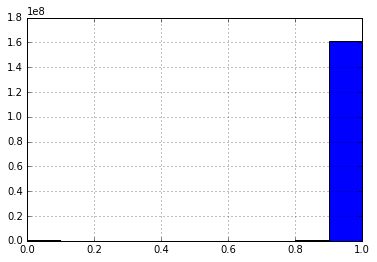

In [15]:
onehop_df['score'].hist()

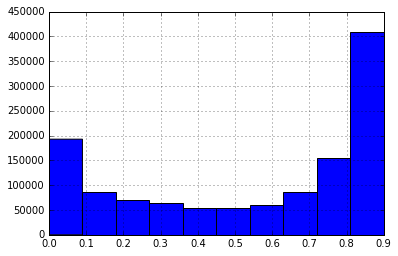

In [16]:
(onehop_df['score'] < 0.9).sum() / len(onehop_df)
onehop_df['score'][onehop_df['score'] < 0.9].hist()

### Compute favorites

In [17]:
%%time

body_a_stats = onehop_df.groupby('body_a').agg({'score': ['min', 'idxmin', 'size']})
body_a_stats.columns = ['min_score', 'min_index', 'edge_count']

body_b_stats = onehop_df.groupby('body_b').agg({'score': ['min', 'idxmin', 'size']})
body_b_stats.columns = ['min_score', 'min_index', 'edge_count']

merged_body_stats = pd.DataFrame(body_a_stats).merge(body_b_stats, 'outer',
                                                     left_index=True, right_index=True,
                                                     suffixes=['_a', '_b'])

# Combine scores/indexes and edge counts, and record which side of the edge the score came from.
min_scores = merged_body_stats[['min_score_a', 'min_score_b']].min(axis=1)
edge_counts = merged_body_stats[['edge_count_a', 'edge_count_b']].sum(axis=1).astype(np.uint32)

min_index = merged_body_stats['min_index_b'].copy()
pos_a = merged_body_stats['min_score_a'] < merged_body_stats['min_score_b']
min_index.loc[pos_a] = merged_body_stats['min_index_a']

sides = pd.Series('b', index=merged_body_stats.index)
sides.loc[pos_a] = 'a'
sides.loc[min_index.isnull()] = 'x'
sides = sides.astype('category')

body_stats = pd.DataFrame({'min_score': min_scores,
                           'min_index': min_index,
                           'edge_count': edge_counts,
                           'side': sides})

body_stats = body_stats.drop(0).query('side != "x"')

onehop_df['is_favorite_of_a'] = False
onehop_df['is_favorite_of_b'] = False

body_a_favorite_edges = body_stats.query("side == 'a'")['min_index'].astype(np.int64)
body_b_favorite_edges = body_stats.query("side == 'b'")['min_index'].astype(np.int64)

onehop_df.loc[body_a_favorite_edges, 'is_favorite_of_a'] = True
onehop_df.loc[body_b_favorite_edges, 'is_favorite_of_b'] = True

onehop_favorites_df = onehop_df.query('is_favorite_of_a or is_favorite_of_b')
onehop_mutual_favorites_df = onehop_favorites_df.query('is_favorite_of_a and is_favorite_of_b')

CPU times: user 5min 26s, sys: 37.5 s, total: 6min 4s
Wall time: 4min 53s


In [102]:
import numpy as np
import pandas as pd

def compute_favorites(edge_table_df):
    body_a_stats = edge_table_df.groupby('body_a').agg({'score': ['min', 'idxmin', 'size']})
    body_a_stats.columns = ['min_score', 'min_index', 'edge_count']
    
    body_b_stats = edge_table_df.groupby('body_b').agg({'score': ['min', 'idxmin', 'size']})
    body_b_stats.columns = ['min_score', 'min_index', 'edge_count']
    
    merged_body_stats = pd.DataFrame(body_a_stats).merge(body_b_stats, 'outer',
                                                         left_index=True, right_index=True,
                                                         suffixes=['_a', '_b'])
    
    # Combine scores/indexes and edge counts, and record which
    # position (a or b) the body was in for its best edge.
    min_scores = merged_body_stats[['min_score_a', 'min_score_b']].min(axis=1)
    edge_counts = merged_body_stats[['edge_count_a', 'edge_count_b']].sum(axis=1).astype(np.uint32)
    
    min_index = merged_body_stats['min_index_b'].copy()
    pos_a = merged_body_stats['min_score_a'] < merged_body_stats['min_score_b']
    min_index.loc[pos_a] = merged_body_stats['min_index_a']
    
    sides = pd.Series('b', index=merged_body_stats.index)
    sides.loc[pos_a] = 'a'
    sides.loc[min_index.isnull()] = 'x'
    sides = sides.astype('category')
    
    # body_favorites is indexed by body
    body_favorites = pd.DataFrame({'min_score': min_scores,
                               'min_index': min_index,
                               'edge_count': edge_counts,
                               'side': sides})
    
    body_favorites = body_favorites.drop(0).query('side != "x"')
    return body_favorites


def mark_favorites(edge_table_df, body_favorites):
    favorite_flags_df = pd.DataFrame(columns=['is_favorite_of_a', 'is_favorite_of_b'], index=edge_table_df.index)
    favorite_flags_df['is_favorite_of_a'] = False
    favorite_flags_df['is_favorite_of_b'] = False
    
    body_a_favorite_edges = body_favorites.query("side == 'a'")['min_index'].astype(np.int64)
    body_b_favorite_edges = body_favorites.query("side == 'b'")['min_index'].astype(np.int64)
    
    favorite_flags_df.loc[body_a_favorite_edges, 'is_favorite_of_a'] = True
    favorite_flags_df.loc[body_b_favorite_edges, 'is_favorite_of_b'] = True
    
    return favorite_flags_df


def extract_favorites(edge_table_df, favorite_flags_df, only_mutual=False):
    if only_mutual:
        selected = favorite_flags_df.query('is_favorite_of_a and is_favorite_of_b')
    else:
        selected = favorite_flags_df.query('is_favorite_of_a or is_favorite_of_b')
    
    return edge_table_df.loc[selected.index]

In [97]:
%time onehop_body_favorites_df = compute_favorites(onehop_df)

CPU times: user 4min, sys: 21.2 s, total: 4min 21s
Wall time: 3min 32s


In [98]:
%time onehop_favorite_flags_df = mark_favorites(onehop_df, onehop_body_favorites_df)

CPU times: user 51.1 s, sys: 7 s, total: 58.1 s
Wall time: 48.4 s


In [103]:
%time onehop_favorites_df2 = extract_favorites(onehop_df, onehop_favorite_flags_df)

CPU times: user 10.3 s, sys: 4.75 s, total: 15.1 s
Wall time: 657 ms


In [104]:
(onehop_favorites_df2 == onehop_favorites_df).all()

id_a                True
id_b                True
xa                  True
ya                  True
za                  True
xb                  True
yb                  True
zb                  True
caa                 True
cab                 True
cba                 True
cbb                 True
iou                 True
da                  True
db                  True
resolution          True
body_a              True
body_b              True
important_a         True
important_b         True
score               True
is_favorite_of_a    True
is_favorite_of_b    True
dtype: bool

### Threshold favorites

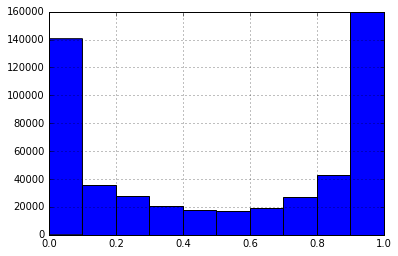

In [59]:
# Distribution of best scores
# (keep in mind that we inverted Michal's score: Now lower is better.)
body_stats['min_score'].hist()

In [18]:
# Michal recommended a cutoff of 0.1 (so, 0.9 for us, after inversion)
SCORE_CUTOFF = 0.9
thresholded_favorites_df = onehop_favorites_df.query('score <= @SCORE_CUTOFF').copy()

num_mutual_favorites = len(onehop_favorites_df.query('is_favorite_of_a and is_favorite_of_b'))
print(f"Found {len(thresholded_favorites_df)} edges after thresholding, "
      f"including {num_mutual_favorites} mutual favorties")

Found 275514 edges after thresholding, including 78027 mutual favorties


,id_a,id_b,xa,ya,za,xb,yb,zb,caa,cab,...,da,db,resolution,body_a,body_b,important_a,important_b,score,is_favorite_of_a,is_favorite_of_b
2279,700032735,700032778,21560,22108,10144,21524,22172,10164,0.924235,0.834134,...,0.001096,0.000680,32,420722828,700032778,True,True,0.058181,True,True
3210,2126584782,2126584808,18676,20788,30052,18672,20896,30204,0.841936,0.233790,...,0.000971,0.000000,32,2063479251,2126584808,True,True,0.766210,False,True
3407,1069672269,1100710468,16636,18600,15608,16744,18724,15688,0.971326,0.418311,...,0.093548,0.011278,32,1069330399,1100710468,True,True,0.581689,False,True
6364,1879095745,1879095991,29732,21700,26368,29696,21744,26428,0.637434,0.000139,...,0.050856,0.046348,32,1879095517,1754612072,True,True,0.621829,True,True
12410,1533243522,1533585380,26096,16172,21808,26056,16252,21896,0.886224,0.057569,...,0.028526,0.003014,32,1533243522,1533585380,True,True,0.045061,False,True
12831,1076120887,1230587164,10704,25924,17348,10768,25916,17364,0.698086,0.000542,...,0.000000,0.000094,32,1041602702,1137836503,True,True,0.898978,False,True
14466,1316659274,1315247992,21332,16204,20512,21160,16132,20400,0.879249,0.948086,...,0.001354,0.032865,32,1285624661,1284213619,True,True,0.120751,False,True
15921,667296328,667296234,22348,20068,9348,22260,19976,9360,0.951768,0.939116,...,0.000149,0.000029,32,667296328,576243061,True,True,0.043699,True,False
16280,1792267502,1946747088,8088,29028,27124,7956,28984,27120,0.891601,0.234297,...,0.174075,0.125175,32,1636402353,1946747088,True,True,0.328334,False,True
16286,1796489866,1827524445,22108,35156,25300,22292,35236,25484,0.960639,0.956585,...,0.002965,0.001338,32,1796148556,1827524445,True,True,0.043415,False,True


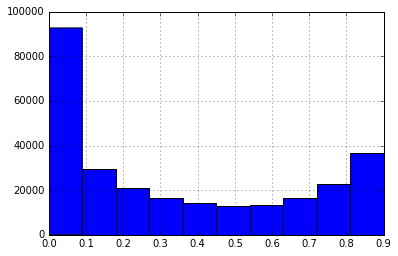

In [20]:
thresholded_favorites_df['score'].hist()

### Remove already-assigned edges

In [23]:
instances = """\
focused_assign
focused_complete
focused_complete_01
focused_complete_02
focused_complete_03
""".split()

sv_pairs = []
for instance in instances:
    for key in fetch_keys(*current_master[:2], instance):
        a,b = key.split('_')
        sv_pairs.append( (int(a), int(b)) )

assigned_edges = np.array(sv_pairs, dtype=np.int64)
assigned_edges.sort(axis=1)

assigned_edges = set(map(tuple, assigned_edges))
print(f"Read {len(assigned_edges)} assigned edges.")

Read 258964 assigned edges.


In [51]:
sorted_pairs = list(map(tuple, np.sort(thresholded_favorites_df[['id_a', 'id_b']].values, axis=1)))
sorted_pairs = pd.Series(sorted_pairs, index=thresholded_favorites_df.index)
is_unassigned = ~sorted_pairs.isin(assigned_edges)
assigned_favorites_df = thresholded_favorites_df.loc[~is_unassigned]
unassigned_favorites_df = thresholded_favorites_df.loc[is_unassigned]
print(f"Found new {len(unassigned_favorites_df)} unassigned favorites")

Found new 65096 unassigned favorites


In [77]:
len(assigned_edges) + len(unassigned_favorites_df)

326174

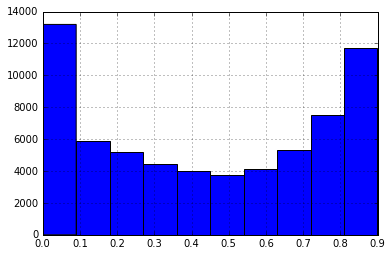

In [26]:
unassigned_favorites_df['score'].hist()

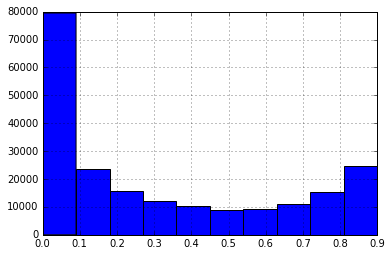

In [52]:
assigned_favorites_df['score'].hist()

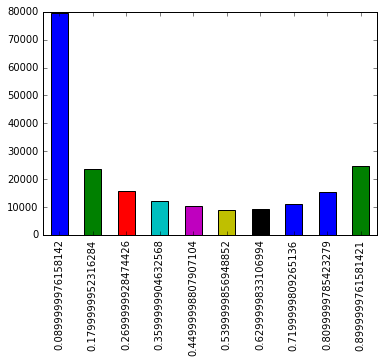

In [55]:
t_count, t_division = np.histogram(thresholded_favorites_df['score'])
u_count, u_division = np.histogram(unassigned_favorites_df['score'])
a_count, a_division = np.histogram(assigned_favorites_df['score'])

assert (t_division == u_division).all()

display(pd.Series(t_count - u_count, index=t_division[1:]).plot(kind='bar', ))

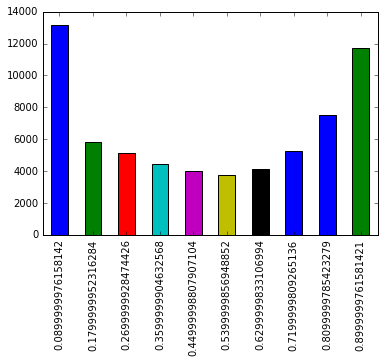

In [56]:
display(pd.Series(t_count - a_count, index=t_division[1:]).plot(kind='bar', ))

In [76]:
len(unassigned_favorites_df)

153943

In [ ]:
new_assignments_df = unassigned_favorites[['id_a', 'id_b', 'xa', 'ya', 'za', 'xb', 'yb', 'zb', 'score']]
new_assignments_df.to_csv('remaining-onehop-assignments-20180731.csv', index=False)

# Tom-foolery

In [ ]:
%%time 
instance = (*current_master[:2], 'segmentation_merged')
keys = fetch_keys(instance)

rows = []
errors = []
for key in tqdm(keys):
    value = None
    try:
        value = fetch_key(instance, key, as_json=True)
        rows.append( (value['supervoxel ID 1'],
                      value['supervoxel ID 2'],
                      value['result']) )
    except Exception:
        errors.append(value)

df = pd.DataFrame(rows, columns=['sv_a', 'sv_b', 'decision'])
df['sv_a'] = df['sv_a'].astype(np.uint64)
df['sv_b'] = df['sv_b'].astype(np.uint64)
print(f"Encountered {len(errors)} errors out of {len(keys)}")

In [24]:
df['body_a'] = analysis_mapper.apply(df['sv_a'].values, True)
df['body_b'] = analysis_mapper.apply(df['sv_b'].values, True)

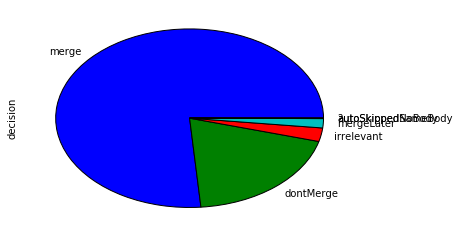

In [28]:
df['decision'].value_counts().plot(kind='pie')

In [29]:
df['decision'].value_counts()

merge                  110108
dontMerge               28043
irrelevant               3540
mergeLater               2424
?                          57
autoSkippedNoBody          28
autoSkippedSameBody        14
Name: decision, dtype: int64

In [30]:
df.to_csv('focused-decisions-20180801.csv')

In [32]:
len(df.query("decision == 'merge' or decision == 'dontMerge'"))

138151

In [ ]:
%time twohop_table = np.concatenate(table_chunks)

In [ ]:
twohop_scores = calc_scores(twohop_table)

In [ ]:
%time twohop_df = pd.DataFrame.from_records(twohop_table)

In [ ]:
twohop_df['score'] = twohop_scores

In [ ]:
%time twohop_subset_df = twohop_df.query('body_a % 20 == 0 or body_b % 20 == 0').copy()

In [ ]:
twohop_subset_df.shape

In [ ]:
del twohop_table
del twohop_df
del twohop_scores

In [ ]:
%%time
body_a_stats = twohop_subset_df.groupby('body_a').agg({'score': ['min']})
body_a_stats.columns = ['min_score']

body_b_stats = twohop_subset_df.groupby('body_b').agg({'score': ['min']})
body_b_stats.columns = ['min_score']

In [ ]:
%%time
merged_body_stats = pd.DataFrame(body_a_stats).merge(body_b_stats, 'outer', left_index=True, right_index=True,
                                                      suffixes=['_a', '_b'])

In [ ]:
%%time

# Combine scores/indexes and edge counts, and record which side of the edge the score came from.
min_scores = merged_body_stats[['min_score_a', 'min_score_b']].min(axis=1)
edge_counts = merged_body_stats[['edge_count_a', 'edge_count_b']].sum(axis=1).astype(np.uint32)

min_index = merged_body_stats['min_index_b'].copy()
pos_a = merged_body_stats['min_score_a'] < merged_body_stats['min_score_b']
min_index.loc[pos_a] = merged_body_stats['min_index_a']

sides = pd.Series('b', index=merged_body_stats.index)
sides.loc[pos_a] = 'a'
sides.loc[min_index.isnull()] = 'x'
sides = sides.astype('category')

twohop_body_stats = pd.DataFrame({'min_score': min_scores,
                                  'min_index': min_index,
                                  'edge_count': edge_counts,
                                  'side': sides})

In [ ]:
q = '(index in @important_bodies) and (index % 20 == 0)'
twohop_body_stats.query(q)['min_score'].hist()

In [ ]:
twohop_subset_df.iloc[:10].values.flags

In [ ]:
onehop_df['resolution'].value_counts().plot(kind='pie')

In [ ]:
onehop_df['resolution'].value_counts() / len(onehop_df['resolution'])

In [ ]:
%%time
best_edges_index = body_stats.drop(0).query('side != "x"')['min_index'].astype(np.int64)
best_onehop_df = onehop_df.loc[best_edges_index]

In [34]:
best_onehop_df.shape

NameError: name 'best_onehop_df' is not defined

In [ ]:
resolution_fractions = best_onehop_df['resolution'].value_counts() / len(best_onehop_df['resolution'])
display(resolution_fractions)
resolution_fractions.plot(kind='pie')

In [ ]:
SMALL_BODY_CUTOFF = 155
small_body_stats = body_stats.drop(0).query('side != "x" and edge_count <= @SMALL_BODY_CUTOFF')
small_best_edges_index = small_body_stats['min_index'].astype(np.int64)

np.random.seed(0)
random_edges = np.random.choice(small_best_edges_index.values, 100, False)
assignment_table = onehop_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'test-assignment-SMALL-BODIES-20180725.json')


In [ ]:
SCORE_CUTOFF = 0.9
good_score_body_stats = body_stats.drop(0).query('side != "x" and min_score <= @SCORE_CUTOFF')
good_best_edges_index = good_score_body_stats['min_index'].astype(np.int64)

print(f"Found {len(good_score_body_stats)}/{len(body_stats)} bodies with a good edge")

np.random.seed(0)
random_edges = np.random.choice(good_best_edges_index.values, 100, False)
assignment_table = onehop_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'test-assignment-good-edges-20180725.json')


In [ ]:
SCORE_CUTOFF = 0.9
weak_score_body_stats = body_stats.drop(0).query('side != "x" and min_score > @SCORE_CUTOFF')
weak_best_edges_index = weak_score_body_stats['min_index'].astype(np.int64)

print(f"Found {len(weak_score_body_stats)}/{len(body_stats)} bodies with a weak edge")

np.random.seed(0)
random_edges = np.random.choice(weak_best_edges_index.values, 100, False)
assignment_table = onehop_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'test-assignment-weak-edges-20180725.json')


In [ ]:
mutal_favorites = onehop_df.query('score <= @SCORE_CUTOFF and is_favorite_of_a and is_favorite_of_b')
print(f"Found {len(mutal_favorites)} mutual favorites")

In [ ]:
body_stats.query('edge_count > 0').shape

In [ ]:
348863 - 73350

In [ ]:
spec1.iloc[:10]

In [11]:
analysis_mapping = fetch_mappings(analysis_node)
analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

Fetching http://emdata3:8900/api/node/662e/segmentation/mappings...
Fetching http://emdata3:8900/api/node/662e/segmentation/mappings took 0:00:30.986914
Parsing mapping...
Parsing mapping took 0:00:06.001045


In [ ]:
%%time
spec1['body_a'] = analysis_mapper.apply(spec1['id_a'].values, True)
spec1['body_b'] = analysis_mapper.apply(spec1['id_b'].values, True)

In [ ]:
spec1_important = spec1.query('(body_a in @important_bodies) and (body_b in @important_bodies)')

In [ ]:
spec1_important.shape

In [ ]:
my_best = set(map(tuple, np.sort(best_onehop_df[['id_a', 'id_b']].values, axis=1)))

In [ ]:
spec1_important_edges = set(map(tuple, np.sort(spec1_important[['id_a', 'id_b']].values, axis=1)))

In [ ]:
print(f"Did not recover {len(spec1_important_edges - my_best)} out of {len(spec1_important)} of Michal's merges")

In [ ]:
analysis_node

509238

In [12]:
new_edges_df = pd.read_csv('hemibrain_662edc_equivs_from_v2_32nm_5563382-FILTERED.csv')
new_important_edges_df = new_edges_df.query('body_a in @important_bodies or body_b in @important_bodies')

In [13]:
len(new_important_edges_df)

136667

In [53]:
np.random.seed(0)
random_edges = np.random.choice(new_important_edges_df.index.values, 200, False)
assignment_table = new_important_edges_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'hemibrain_662edc_equivs_from_v2_32nm_5563382-SAMPLE-ASSIGNMENT-2.json')

In [62]:
new_important_edges_df.iloc[:5]

,id_a,id_b,xa,ya,za,xb,yb,zb,body_a,body_b
0,483776508,1169273038,18468,26768,16548,18464,26768,16548,329983926,1169268432
1,1561139661,1561139672,18964,11956,21948,18960,11956,21948,800929667,1561139672
3,1262148664,1293187714,29756,26580,18004,29752,26580,18004,1262148664,1262809553
4,2254161019,2254157176,21100,25072,31664,21100,25076,31664,2254161019,2041993364
6,536404555,106979579,29268,11032,7804,29272,11032,7804,536404555,106979579


In [69]:
from neuclease.merge_table import normalize_recarray_inplace
new_important_edges = new_important_edges_df.to_records(index=False)
cols_a = list(filter(lambda col: col[-1] == 'a', new_important_edges_df.columns))
cols_b = list(filter(lambda col: col[-1] == 'b', new_important_edges_df.columns))

normalize_recarray_inplace(new_important_edges, 'id_a', 'id_b', cols_a, cols_b)
new_important_edges_df = pd.DataFrame(new_important_edges)
assert new_important_edges_df.eval('id_a < id_b').all()

In [70]:
new_important_edges_df.shape

(136667, 10)

In [72]:
already_reviewed_keys = fetch_keys(*current_master[:2], 'segmentation_merged')
already_reviewed_pairs = [(int(a), int(b)) for a,b in (s.split('+') for s in already_reviewed_keys)]

In [79]:
already_reviewed_ids = np.array(already_reviewed_pairs, dtype=np.uint64)
already_reviewed_ids.sort(axis=1)
already_reviewed_ids = pd.DataFrame(already_reviewed_ids, columns=['id_a', 'id_b'], dtype=np.uint64)
assert already_reviewed_ids.eval('id_a < id_b').all()

In [95]:
new_important_edges_df['edge_id'] = list(map(tuple, new_important_edges_df[['id_a', 'id_b']].values))
already_reviewed_ids['edge_id'] = list(map(tuple, already_reviewed_ids[['id_a', 'id_b']].values))

unreviewed_new_important_df = new_important_edges_df[~new_important_edges_df['edge_id'].isin(already_reviewed_ids['edge_id'])]
del unreviewed_new_important_df['edge_id']
unreviewed_new_important_df.to_csv('hemibrain_662edc_equivs_from_v2_32nm_5563382-FILTERED-UNREVIEWED.csv', header=True, index=False)

In [14]:
print(unreviewed_new_important_df.shape)

NameError: name 'unreviewed_new_important_df' is not defined

In [102]:
len(unreviewed_new_important_df) / 500

242.866

In [103]:
from neuclease.merge_table import generate_assignments
generate_assignments(unreviewed_new_important_df, 500, 'hemibrain_662edc_equivs_from_v2_32nm-ASSIGNMENTS')

100%|██████████| 242/242 [00:08<00:00, 30.12it/s]


In [101]:
!head /nrs/flyem/bergs/complete-ffn-agglo/hemibrain_662edc_equivs_from_v2_32nm_5563382-FILTERED-UNREVIEWED.csv

id_a,id_b,xa,ya,za,xb,yb,zb,body_a,body_b
483776508,1169273038,18468,26768,16548,18464,26768,16548,329983926,1169268432
1561139661,1561139672,18964,11956,21948,18960,11956,21948,800929667,1561139672
1262148664,1293187714,29756,26580,18004,29752,26580,18004,1262148664,1262809553
2254157176,2254161019,21100,25076,31664,21100,25072,31664,2041993364,2254161019
106979579,536404555,29272,11032,7804,29268,11032,7804,106979579,536404555
106979579,556137599,24064,36644,7832,24064,36640,7832,106979579,556137599
1222592726,1658078513,27320,16688,23580,27320,16692,23580,1006967204,1658074471
1994868647,2005342170,8204,17352,29184,8200,17352,29184,1713948917,1498418998
769505273,1951219527,11724,34916,27796,11724,34916,27792,769505273,1951219527


In [ ]:
unreviewed_new_important_df

In [61]:
originally_assigned_df = pd.DataFrame(list(assigned_edges), columns=['id_a', 'id_b'], dtype=np.uint64)
originally_assigned_df['body_a'] = analysis_mapper.apply(originally_assigned_df['id_a'].values, True)
originally_assigned_df['body_b'] = analysis_mapper.apply(originally_assigned_df['id_b'].values, True)

originally_assigned = originally_assigned_df[['body_a', 'body_b']].values
newly_assigned = unassigned_favorites_df[['body_a', 'body_b']].values
new_method_edges = new_important_edges_df[['body_a', 'body_b']].values

old_and_new = np.concatenate( (originally_assigned,
                               newly_assigned,
                               #thresholded_favorites_df[['body_a', 'body_b']].values,
                               new_method_edges) )
old_and_new.sort(axis=1)

old_and_new_df = pd.DataFrame(old_and_new, columns=['body_x', 'body_y'])
dupes = old_and_new_df.duplicated()




print(f"The new edges ({len(new_method_edges)}) include {dupes.sum()} "
      f"duplicates of previously chosen favorites, and {len(new_method_edges) - dupes.sum()} new ones.")

NameError: name 'analysis_mapper' is not defined

In [92]:
len(originally_assigned_df) + len(newly_assigned) + len(new_method_edges) - dupes.sum()

428272

In [95]:
428272 * 0.7

299790.39999999997

In [79]:
unassigned_favorites_df.shape

(153943, 23)

In [80]:
assigned_edges.shape

AttributeError: 'set' object has no attribute 'shape'

In [99]:
assignment_path = ('/nrs/flyem/bergs/complete-ffn-agglo/'
                   'hemibrain_662edc_equivs_from_v2_32nm_5563382-SAMPLE-ASSIGNMENT-2.json')
assignment = json.load(open(assignment_path, 'r'))
edges = []
for task in assignment["task list"]:
    sv_a = task["supervoxel ID 1"]
    sv_b = task["supervoxel ID 2"]
    edges.append( (sv_a, sv_b) )

knectc_merge_instance = ('emdata1:8400', '363f', 'segmentation_merged')

results = []
for (sv_a, sv_b) in tqdm_notebook(edges):
    value = fetch_key(knectc_merge_instance, f"{sv_a}+{sv_b}", as_json=True)
    results.append( value["result"] )

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

,decision
merge,154
dontMerge,28
irrelevant,14
mergeLater,4


---------------------------------------
Merge rate (excluding irrelevant): 0.85
---------------------------------------


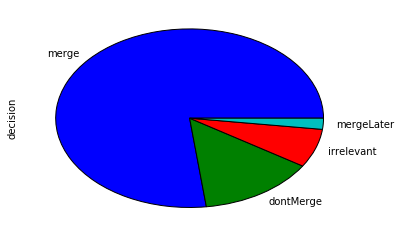

In [132]:
chris_decisions_df = pd.DataFrame(edges, columns=['sv_a', 'sv_b'])
chris_decisions_df['decision'] = results
chris_decision_counts = chris_decisions_df['decision'].value_counts()
display(pd.DataFrame(chris_decision_counts))

merge_count = chris_decision_counts['merge'] + chris_decision_counts['mergeLater']
dont_merge_count = chris_decision_counts['dontMerge']
merge_rate = merge_count / (merge_count + dont_merge_count)

print("---------------------------------------")
print(f"Merge rate (excluding irrelevant): {merge_rate:.2f}")
print("---------------------------------------")

_ = chris_decision_counts.plot(kind='pie')

Merge rate: 0.8494623655913979


In [ ]:
136667 - 34569

In [135]:
chris_decisions_df.to_csv('hemibrain_662edc_equivs_from_v2_32nm_5563382-SAMPLE-ASSIGNMENT-2-DECISIONS.csv', index=False)

### Ruchi and Shinya

In [66]:
marisa_bodies = "614413183 645456880 676479156 707854989 707858790 707863263 768590452 861251038 1138212774 1882009576 2147677469 2241451334 5813011118 5813022814 5813034824 5813035694 5813038097"
marisa_bodies = set(map(int, marisa_bodies.split()))

q = 'body_a in @marisa_bodies or body_b in @marisa_bodies'
marisa_favorites_df = onehop_favorites_df.query(q)

In [67]:
marisa_favorites_df.shape

(58, 23)

In [72]:
marisa_bodies_it2 = set(marisa_favorites_df[['body_a', 'body_b']].values.flat)
q = 'body_a in @marisa_bodies_it2 or body_b in @marisa_bodies_it2'
marisa_it2_favorites_df = onehop_favorites_df.query(q)

In [73]:
marisa_it2_favorites_df.shape

(164, 23)

In [86]:
def compute_iterations(table_df, starting_bodies, num_iterations):
    starting_bodies = set(starting_bodies)
    dfs = []

    for _ in range(num_iterations):
        q = 'body_a in @starting_bodies or body_b in @starting_bodies'    
        df = table_df.query(q)

        if len(dfs) == 0 :
            dfs.append(df)
        else:
            prev_df = dfs[-1]
            accum_df = pd.concat((prev_df, df))
            df_filtered = accum_df.drop_duplicates(['body_a', 'body_b']).iloc[len(prev_df):]
            dfs.append( df_filtered )
        starting_bodies = set(dfs[-1][['body_a', 'body_b']].values.flat)
    return dfs

In [92]:
NUM_ITERATIONS = 10
marisa_iteration_dfs = compute_iterations(onehop_favorites_df, marisa_bodies, NUM_ITERATIONS)
for i, df in enumerate(marisa_iteration_dfs, start=1):
    print(f"Iteration {i}: {len(df)}")

print(f"TOTAL: {sum(map(len, marisa_iteration_dfs))}")

Iteration 1: 58
Iteration 2: 106
Iteration 3: 97
Iteration 4: 180
Iteration 5: 113
Iteration 6: 182
Iteration 7: 113
Iteration 8: 182
Iteration 9: 113
Iteration 10: 182
TOTAL: 1326


In [109]:
from neuclease.merge_table import generate_focused_assignment
for i, df in enumerate(marisa_iteration_dfs, start=1):
    df.to_csv(f'marisa-iterations/edge-tables/iteration-{i:02d}.csv', index=False)
    generate_focused_assignment(df, f'marisa-iterations/assignments/iteration-{i:02d}.json')

In [113]:
print(marisa_bodies - set(marisa_iteration_dfs[0][['body_a', 'body_b']].values.flat))

{2241451334, 1138212774, 1882009576, 5813034824, 707858790, 5813035694, 5813038097, 2147677469, 5813022814}


In [119]:
df = marisa_iteration_dfs[0]

sorted_pairs = list(map(tuple, np.sort(df[['id_a', 'id_b']].values, axis=1)))
sorted_pairs = pd.Series(sorted_pairs, index=df.index)
is_unassigned = ~sorted_pairs.isin(assigned_edges)
unassigned_favorites_df = df.loc[is_unassigned]
print(f"{len(unassigned_favorites_df)} of Marisa's edges are previously unassigned")

17 of Marisa's edges are previously unassigned


In [ ]:
from neuclease.dvid import *
master

In [13]:
from neuclease.dvid import *
master_mapping = fetch_complete_mappings(*current_master)

Reading kafka messages from kafka.int.janelia.org:9092 for emdata3:8900 / d585 / segmentation
Reading 380801 kafka messages took 17.63081955909729 seconds
Fetching http://emdata3:8900/api/node/d585/segmentation/mappings...
Fetching http://emdata3:8900/api/node/d585/segmentation/mappings took 0:00:32.507517
Parsing mapping...
Parsing mapping took 0:00:09.022536
Constructing missing identity-mappings...
Constructing missing identity-mappings took 0:00:21.473158


In [14]:
master_mapping.shape

(41078989,)

In [15]:
master_mapping.index.name

'sv'

In [16]:
body_counts = master_mapping.value_counts()

In [17]:
body_counts[:10]

2567475583    10384
5813024523    10043
5813050455     9597
5813050499     9460
1497973422     8748
5813024096     8172
950880008      8076
5813027276     7519
298258513      6948
1135441187     6430
Name: body, dtype: int64

In [18]:
body_counts.shape

(9670991,)